# This notebook take the input from omega_analysis.ipynb output omega*.npy, and using {} to cluster them.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans
from deeptime.clustering import RegularSpace
from deeptime.clustering import BoxDiscretization

import mdtraj as md
import re, math, os, shutil

import warnings; warnings.simplefilter('ignore')
from collections import Counter

### Import the data 

In [2]:
# import omega data
omegas = np.load('omega_data/omegas_state0.npy')
print(omegas)
print(f"omegas.shape: {omegas.shape}")
print(f"omegas.dtype: {omegas.dtype}")

[[ 170.2706     176.17532    178.87288  ]
 [-162.09203   -161.30649   -179.31964  ]
 [ 178.32304   -136.36572   -167.01295  ]
 ...
 [-163.823        2.2569506 -162.57375  ]
 [-146.38396     -5.4066076  166.34964  ]
 [-170.84647   -177.96852    169.24368  ]]
omegas.shape: (600030, 3)
omegas.dtype: float32


Saved at: omega_data/Omega_angles_vs_Time_state_0_in_19AE1-4-A.png


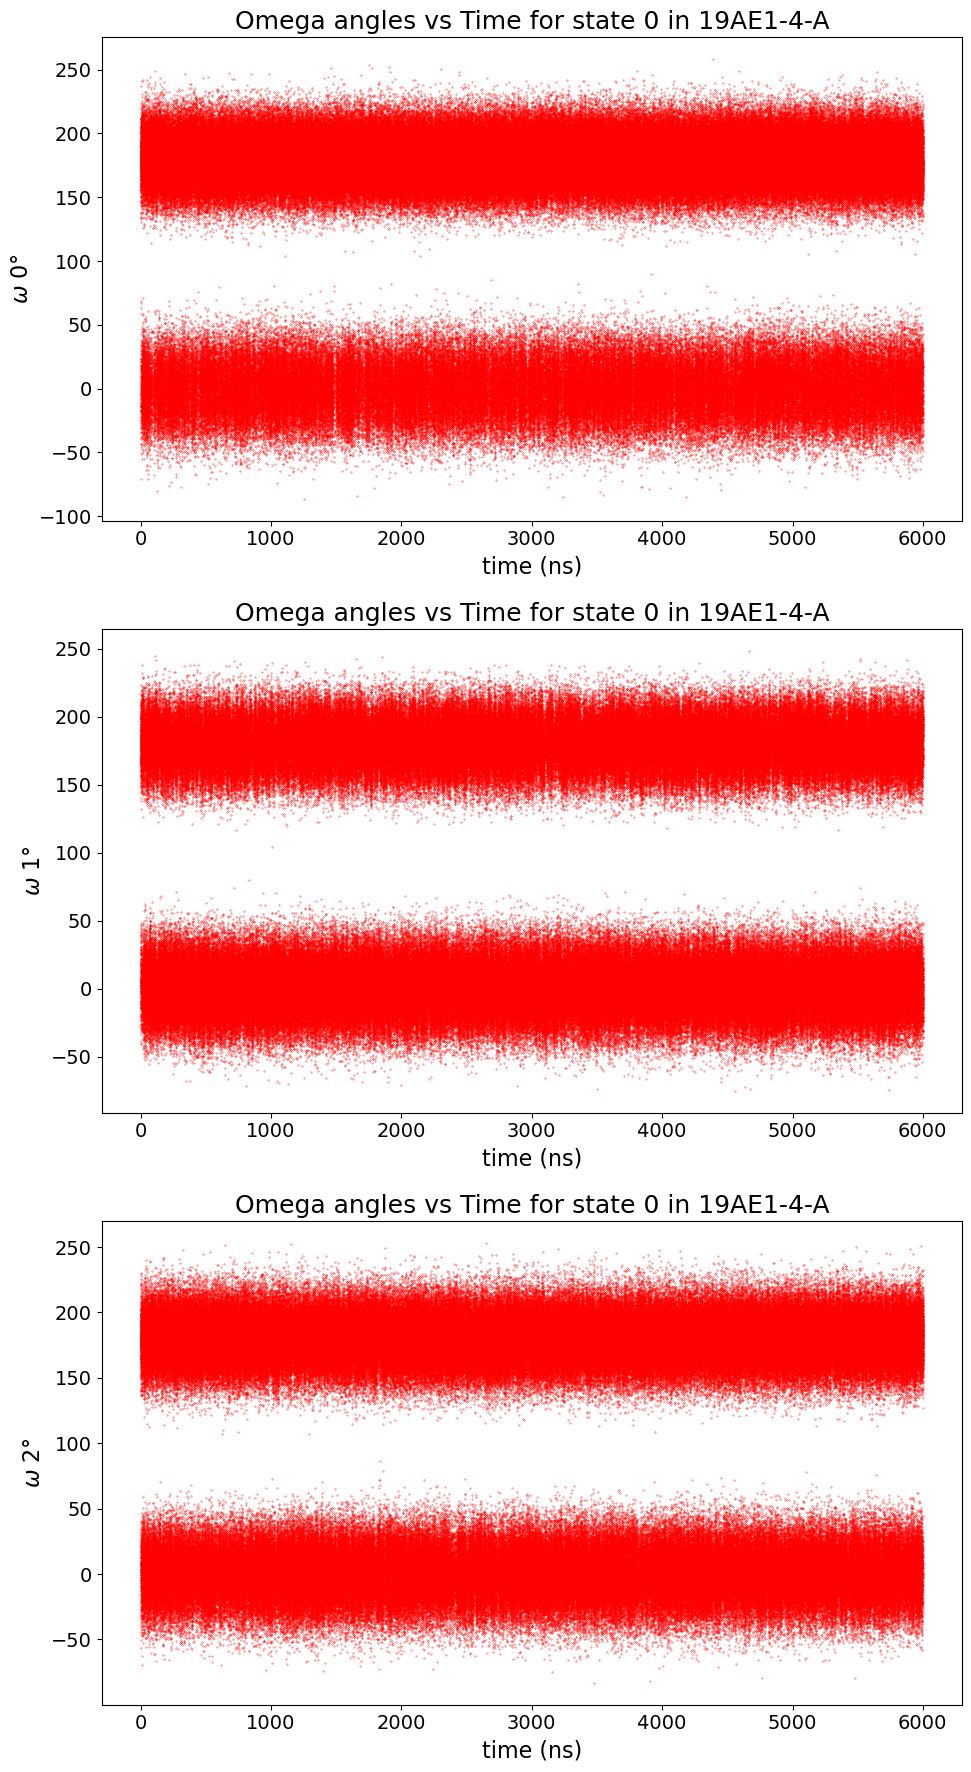

In [3]:
# Plotting the omegas 
omegas = (omegas + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)

start = 1
nsnaps = 600030
t = np.arange(start, nsnaps) * 0.01 # Time axis in ns
residues_to_plot = [0, 1, 2,]
num_residues = len(residues_to_plot)

# Set default font sizes globally
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # legend fontsize

plt.figure(figsize=(10, 18))
for panel, residue in enumerate(residues_to_plot, 1):
    plt.subplot(num_residues, 1, panel)
    plt.plot(t, omegas[start:nsnaps, residue], '.', ms=0.5, color='red')
    plt.xlabel('time (ns)')
    plt.ylabel(f'$\\omega$ {residue}°')
    plt.title(f'Omega angles vs Time for state 0 in 19AE1-4-A')

plt.tight_layout()

# Ensure the directory exists
outfilename = f'omega_data/Omega_angles_vs_Time_state_0_in_19AE1-4-A.png'
plt.savefig(outfilename, transparent=True, dpi=600)
print(f"Saved at: {outfilename}")
plt.show()

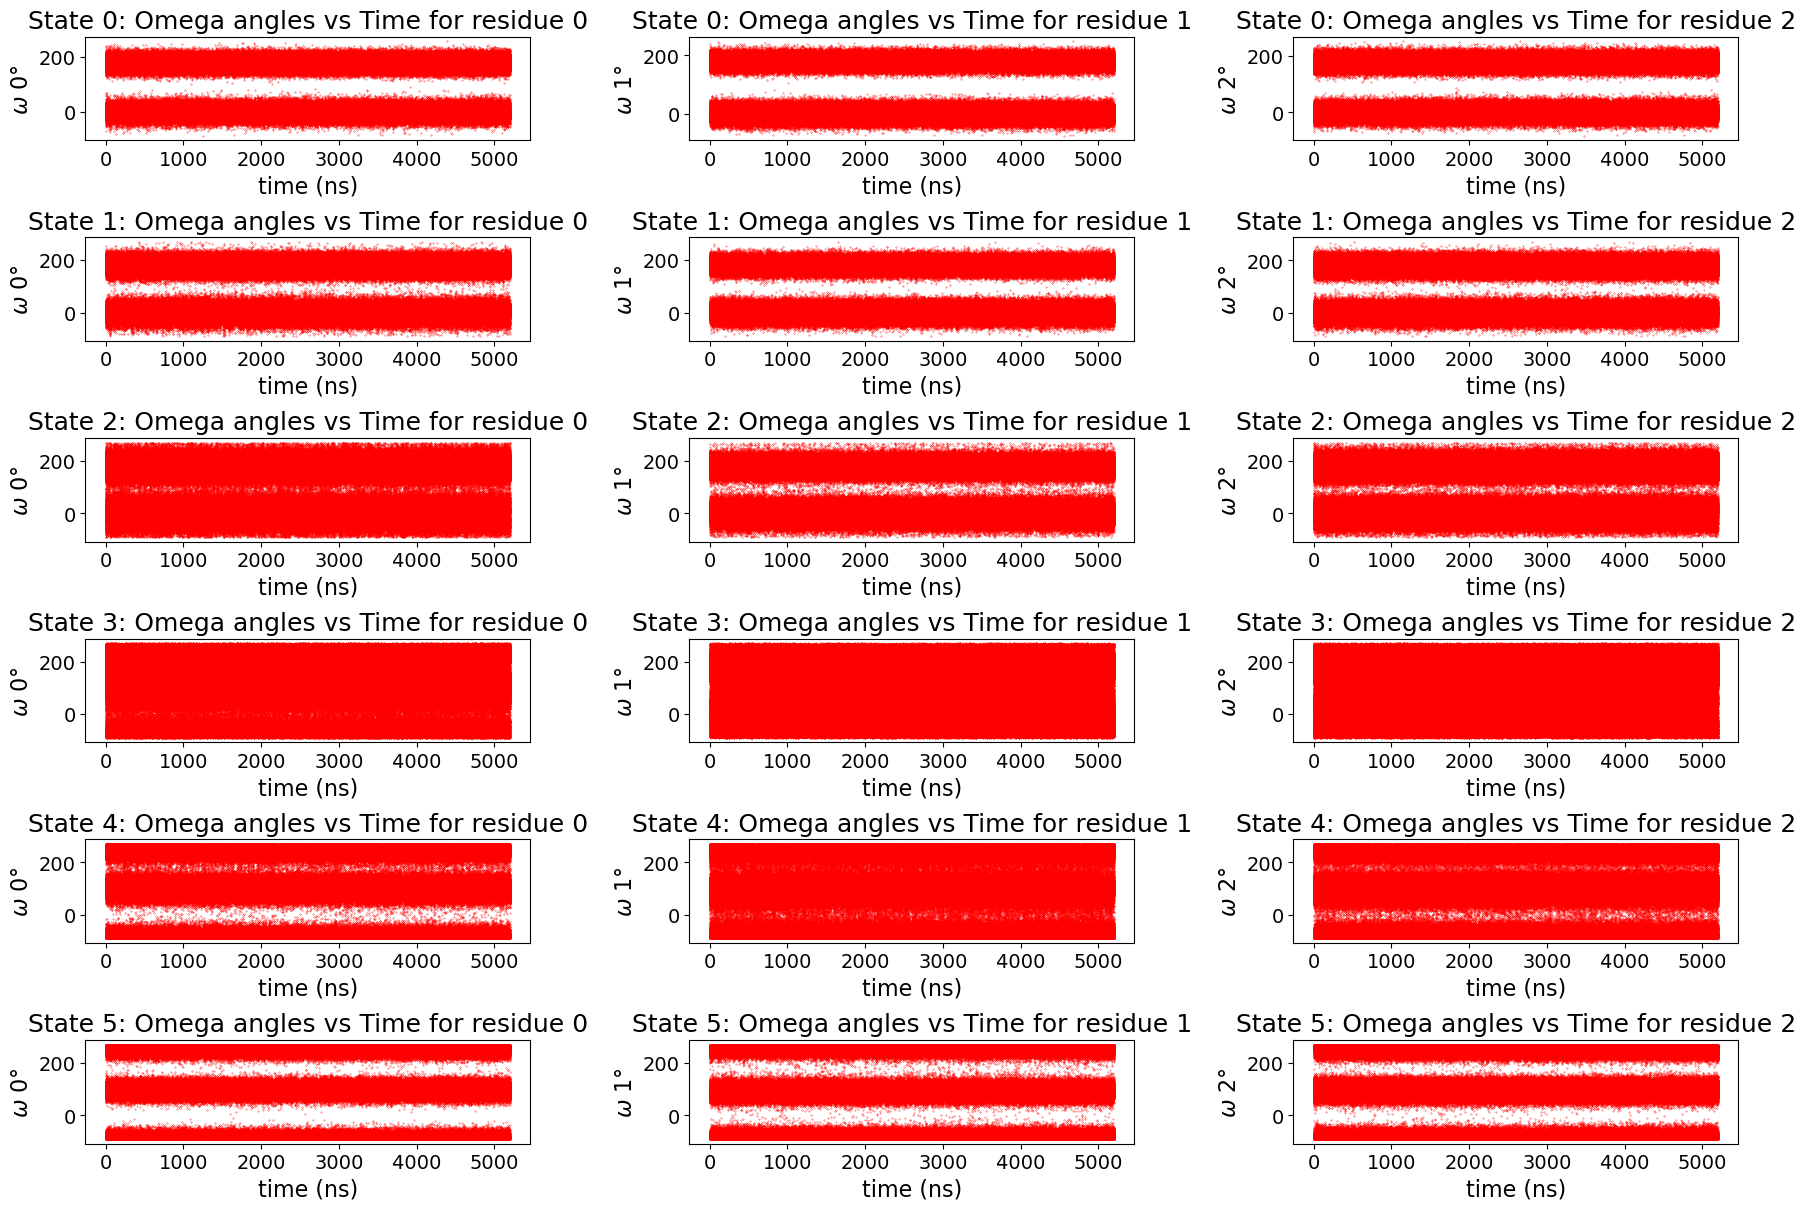

In [4]:
nstates = 6
residues_to_plot = [0, 1, 2]
num_residues = len(residues_to_plot)
start = 0
nsnaps = 520026
t = np.arange(start, nsnaps) * 0.01  # Time axis in ns

# Set default font sizes globally
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # legend fontsize

fig, axs = plt.subplots(nstates, num_residues, figsize=(18, 12), constrained_layout=True)

for i in range(nstates):
    omegas = np.load(f"omega_data/omegas_state{i}.npy")
    omegas = (omegas + 90.0) % 360.0 - 90.0  # Adjust omega values into the range (-90, 270)

    for panel, residue in enumerate(residues_to_plot):
        ax = axs[i, panel] if nstates > 1 else axs[panel]
        ax.plot(t, omegas[start:nsnaps, residue], '.', ms=0.5, color='red')
        ax.set_xlabel('time (ns)')
        ax.set_ylabel(f'$\\omega$ {residue}°')
        ax.set_title(f'State {i}: Omega angles vs Time for residue {residue}')

# Show the final plot
plt.show()

### Clustering Method

In [11]:
regularspace_estimator = RegularSpace(
    dmin=170,        # minimum distance between cluster centers, 180 degree
    max_centers=8,   # maximum number of cluster centers
    n_jobs=8
)

kmean_estimator = KMeans(
    n_clusters=8,              # place 100 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=100000000,        # don't actually perform the optimization, just place centers
    fixed_seed=42,             # Treat this as hyperparameter 
    n_jobs=8,
    progress=tqdm
)

In [12]:
# Fit the omegas data into model 
clustering = regularspace_estimator.fit(omegas).fetch_model()
assignments = clustering.transform(omegas)

print(clustering.cluster_centers)
print(f"Number of cluster centers: {len(clustering.cluster_centers)}")

[[170.2706    176.17532   178.87286  ]
 [184.29428    -4.3558884 154.61101  ]
 [158.86967   149.26996   -36.06339  ]
 [  4.485214    6.847183  177.37915  ]
 [-13.274704  169.28845   230.20654  ]
 [ 15.669052  -23.33995   -12.798889 ]
 [-13.995842  170.29901    -9.57563  ]
 [215.742      -9.93615   -14.938942 ]]
Number of cluster centers: 8


### The population of each cluster:

In [13]:
# count the number of each cluter 
counts = Counter(assignments)
#print(counts)

# Sort the counts 
sorted_counts = dict(sorted(counts.items()))
total_counts = sum(counts.values())
cluster = []

for label, frequency in sorted_counts.items():    
    precentage = (frequency / total_counts) * 100 
    cluster.append(precentage)
    print(f"Assignment {label}: {frequency}, {precentage:.4g}%")

outfile = 'clusters_probability.dat'
np.savetxt(outfile, cluster)

Assignment 0: 108955, 18.16%
Assignment 1: 138641, 23.11%
Assignment 2: 83684, 13.95%
Assignment 3: 55106, 9.184%
Assignment 4: 42424, 7.07%
Assignment 5: 38866, 6.477%
Assignment 6: 36737, 6.123%
Assignment 7: 95617, 15.94%


#### Analysis the error of each counts 

In [14]:
print(assignments.shape)

(600030,)


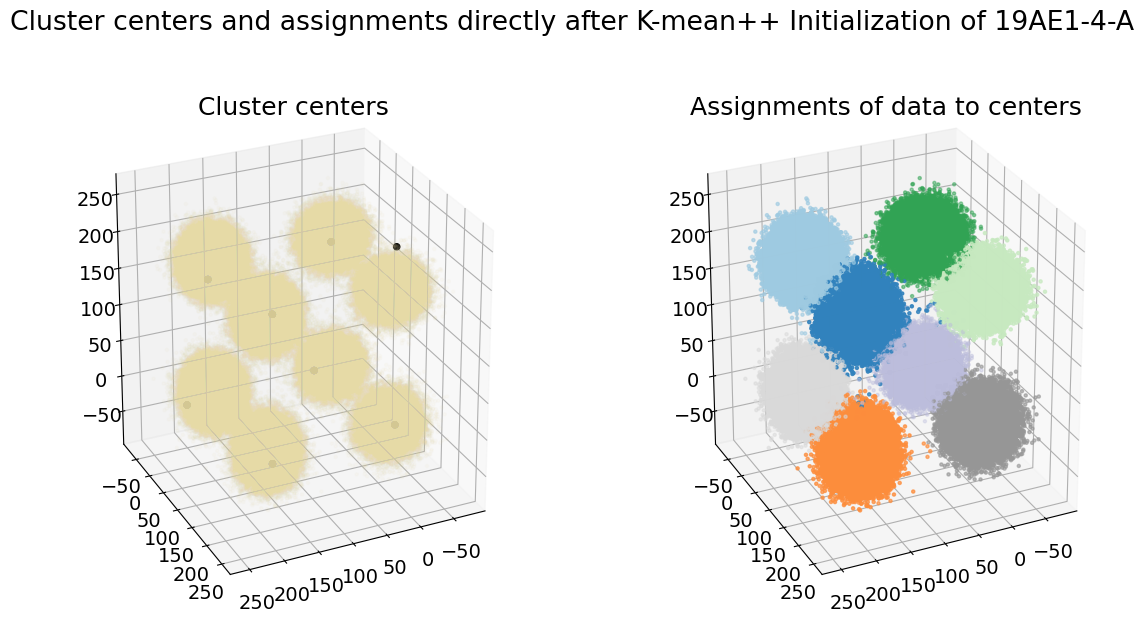

In [15]:
fig = plt.figure(figsize=(14, 7))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c='#E6DAA6', marker='.', alpha=0.05)
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', cmap='tab20c')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

fig.suptitle('Cluster centers and assignments directly after K-mean++ Initialization of 19AE1-4-A')
fig.savefig('omega_data/cluster_centers_and_assignments.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

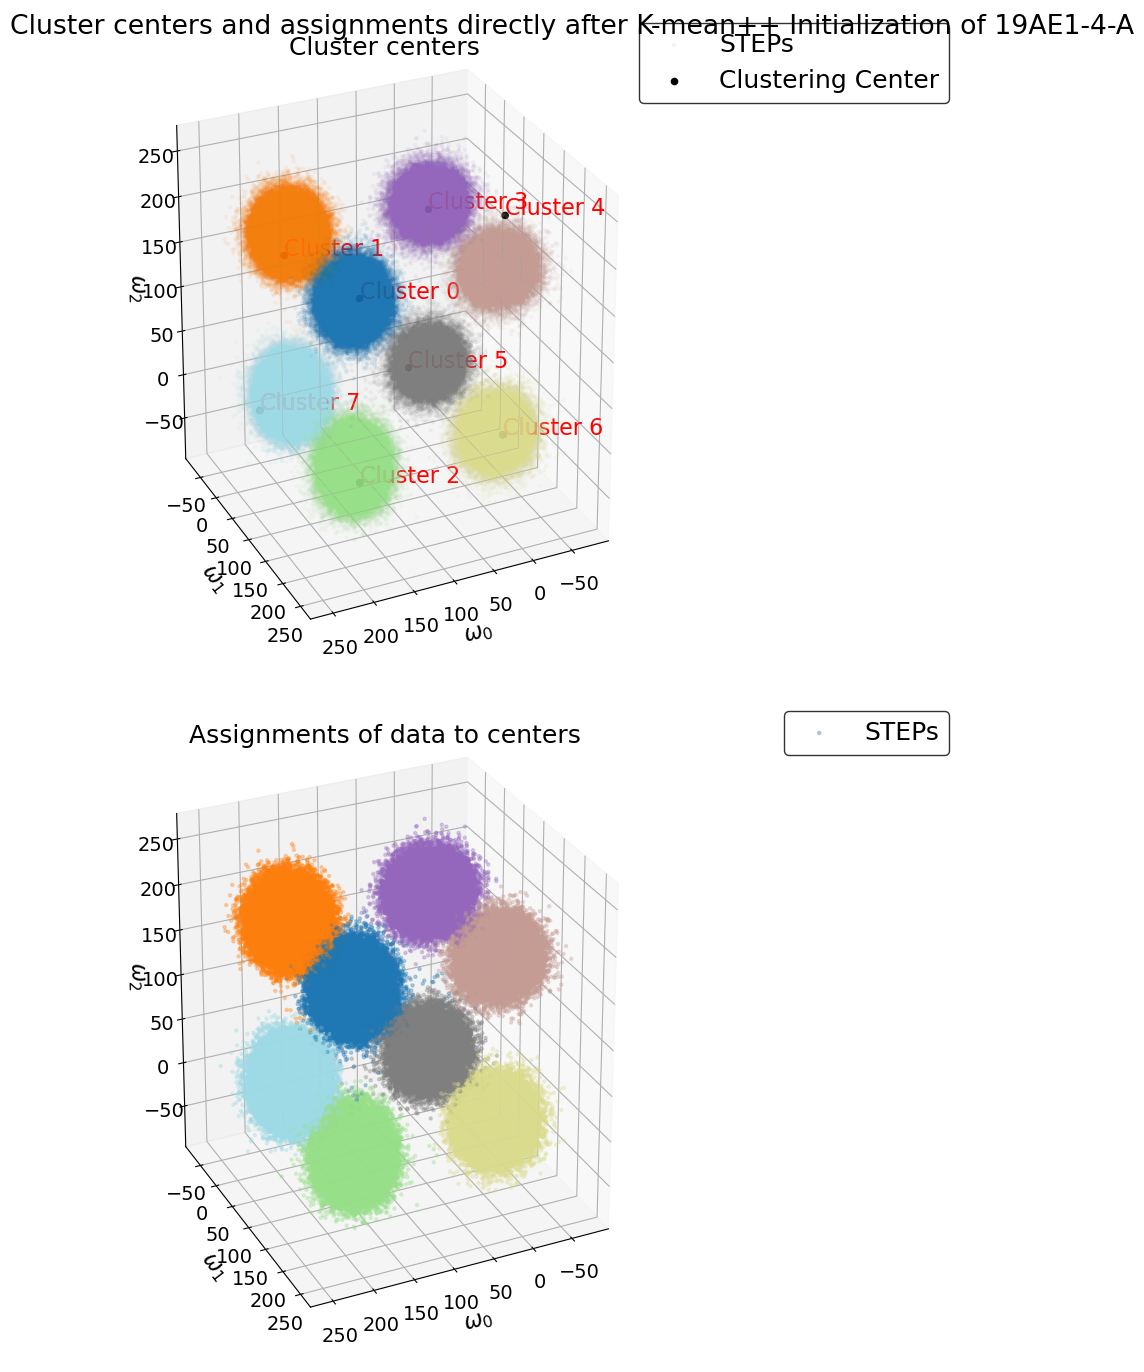

In [16]:
fig = plt.figure(figsize=(10, 14))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(211, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', alpha=0.05,cmap='tab20',label='STEPs')
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1, label='Clustering Center')
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Label each cluster center
for i, (x, y, z) in enumerate(clustering.cluster_centers):
    ax1.text(x, y, z, f'Cluster {i}', color='red')

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(212, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', alpha=0.3 , cmap='tab20', label='STEPs')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')

# Adding axis labels
ax1.set_xlabel(r'$\omega_0$')
ax1.set_ylabel(r'$\omega_1$')
ax1.set_zlabel(r'$\omega_2$')

ax2.set_xlabel(r'$\omega_0$')
ax2.set_ylabel(r'$\omega_1$')
ax2.set_zlabel(r'$\omega_2$')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()

fig.suptitle('Cluster centers and assignments directly after K-mean++ Initialization of 19AE1-4-A')
fig.savefig('omega_data/cluster_centers_and_assignments.png',transparent=True, dpi=600, bbox_inches='tight')
plt.show()

### Analysis the error of each cluster

In [20]:
# Step 1: Define fragment size and number of fragments
fragment_size = 500  # 5 ns
n_fragments = omegas.shape[0] // fragment_size

# Step 2: Slice data into fragments
fragments = np.array_split(omegas[:n_fragments * fragment_size], n_fragments)

# Step 3: Cluster assignments for the entire dataset
assignments = clustering.transform(omegas)

# Step 4: Initialize containers for <x> and <x^2>
cluster_sums = {cluster: 0 for cluster in range(8)} 
cluster_squares = {cluster: 0 for cluster in range(8)}
cluster_counts = {cluster: 0 for cluster in range(8)}

# Calculate statistics for each fragment
for fragment in fragments:
    fragment_assignments = assignments[:fragment_size]
    assignments = assignments[fragment_size:]  # Update remaining assignments

    # Count assignments in the fragment
    counts = Counter(fragment_assignments)
    for cluster in range(8):
        cluster_sums[cluster] += counts.get(cluster, 0) # 0 ensure that if the cluster is not present in the fragment, a default value of 0 is used
        cluster_squares[cluster] += counts.get(cluster, 0) ** 2
        cluster_counts[cluster] += fragment_size

# Step 5: Calculate error bars for each cluster
error_bars = {}
for cluster in range(8):
    N = n_fragments
    x_avg = cluster_sums[cluster] / cluster_counts[cluster]  # <x>
    x2_avg = cluster_squares[cluster] / cluster_counts[cluster]  # <x^2>
    error = 2 * np.sqrt(x2_avg - x_avg ** 2) / (N - 1)  # Formula
    error_bars[cluster] = error

# Step 6: Print error bars
for cluster, error in error_bars.items():
    #print(f"Cluster {cluster}: Error bar = {error:.6f} ")
    print(f"Cluster {cluster} error is: {error:.6f} ")

Cluster 0 error is: 0.008104 
Cluster 1 error is: 0.009834 
Cluster 2 error is: 0.006458 
Cluster 3 error is: 0.004570 
Cluster 4 error is: 0.003648 
Cluster 5 error is: 0.003624 
Cluster 6 error is: 0.003430 
Cluster 7 error is: 0.007260 
